# Part 1

In [47]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
import numpy as np

# Get the data 
df = pd.read_csv("football.csv", sep=";")
df = df.dropna()
display(df.columns)

X = df.drop(columns="GoalsScored")
scaler = StandardScaler()
X = scaler.fit_transform(X)
X = np.hstack([np.ones((X.shape[0], 1)), X]) # ADD INTERCEPT
y = df["GoalsScored"]

Index(['X_ScoreRateH', 'X_ScoreRateA', 'X_ConcedeRateH', 'X_ConcedeRateA',
       'X_CornerRatioH', 'X_CornerRatioA', 'X_FoulRatioH', 'X_FoulRatioA',
       'GoalsScored'],
      dtype='object')

In [49]:
import pymc as pm

alpha = 10

# Modeling 
with pm.Model() as model:
    beta = pm.Normal("beta", mu = 0, sigma = alpha, shape = X.shape[1])

    # Link function
    mu = pm.math.exp(pm.math.dot(X, beta))

    y_obs = pm.Poisson("y_obs", mu=mu, observed = y)

    trace = pm.sample(1000,chains=4, tune=1000, return_inferencedata=True)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 17 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta[0],0.999,0.015,0.971,1.026,0.0,0.0,7543.0,3070.0,1.0
beta[1],0.082,0.017,0.049,0.112,0.0,0.0,5682.0,2957.0,1.0
beta[2],0.034,0.018,-0.001,0.066,0.0,0.0,5798.0,3313.0,1.0
beta[3],-0.050,0.017,-0.080,-0.018,0.0,0.0,6541.0,3088.0,1.0
beta[4],0.011,0.016,-0.020,0.040,0.0,0.0,5523.0,3151.0,1.0
beta[5],0.015,0.017,-0.017,0.047,0.0,0.0,5919.0,3181.0,1.0
beta[6],0.000,0.017,-0.032,0.032,0.0,0.0,5908.0,2740.0,1.0
beta[7],-0.052,0.016,-0.082,-0.022,0.0,0.0,6210.0,3127.0,1.0
beta[8],-0.020,0.017,-0.051,0.011,0.0,0.0,6087.0,2863.0,1.0


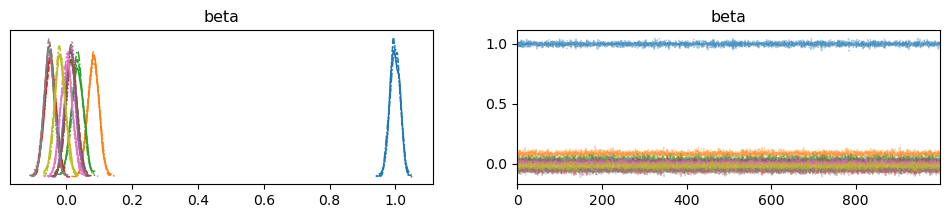

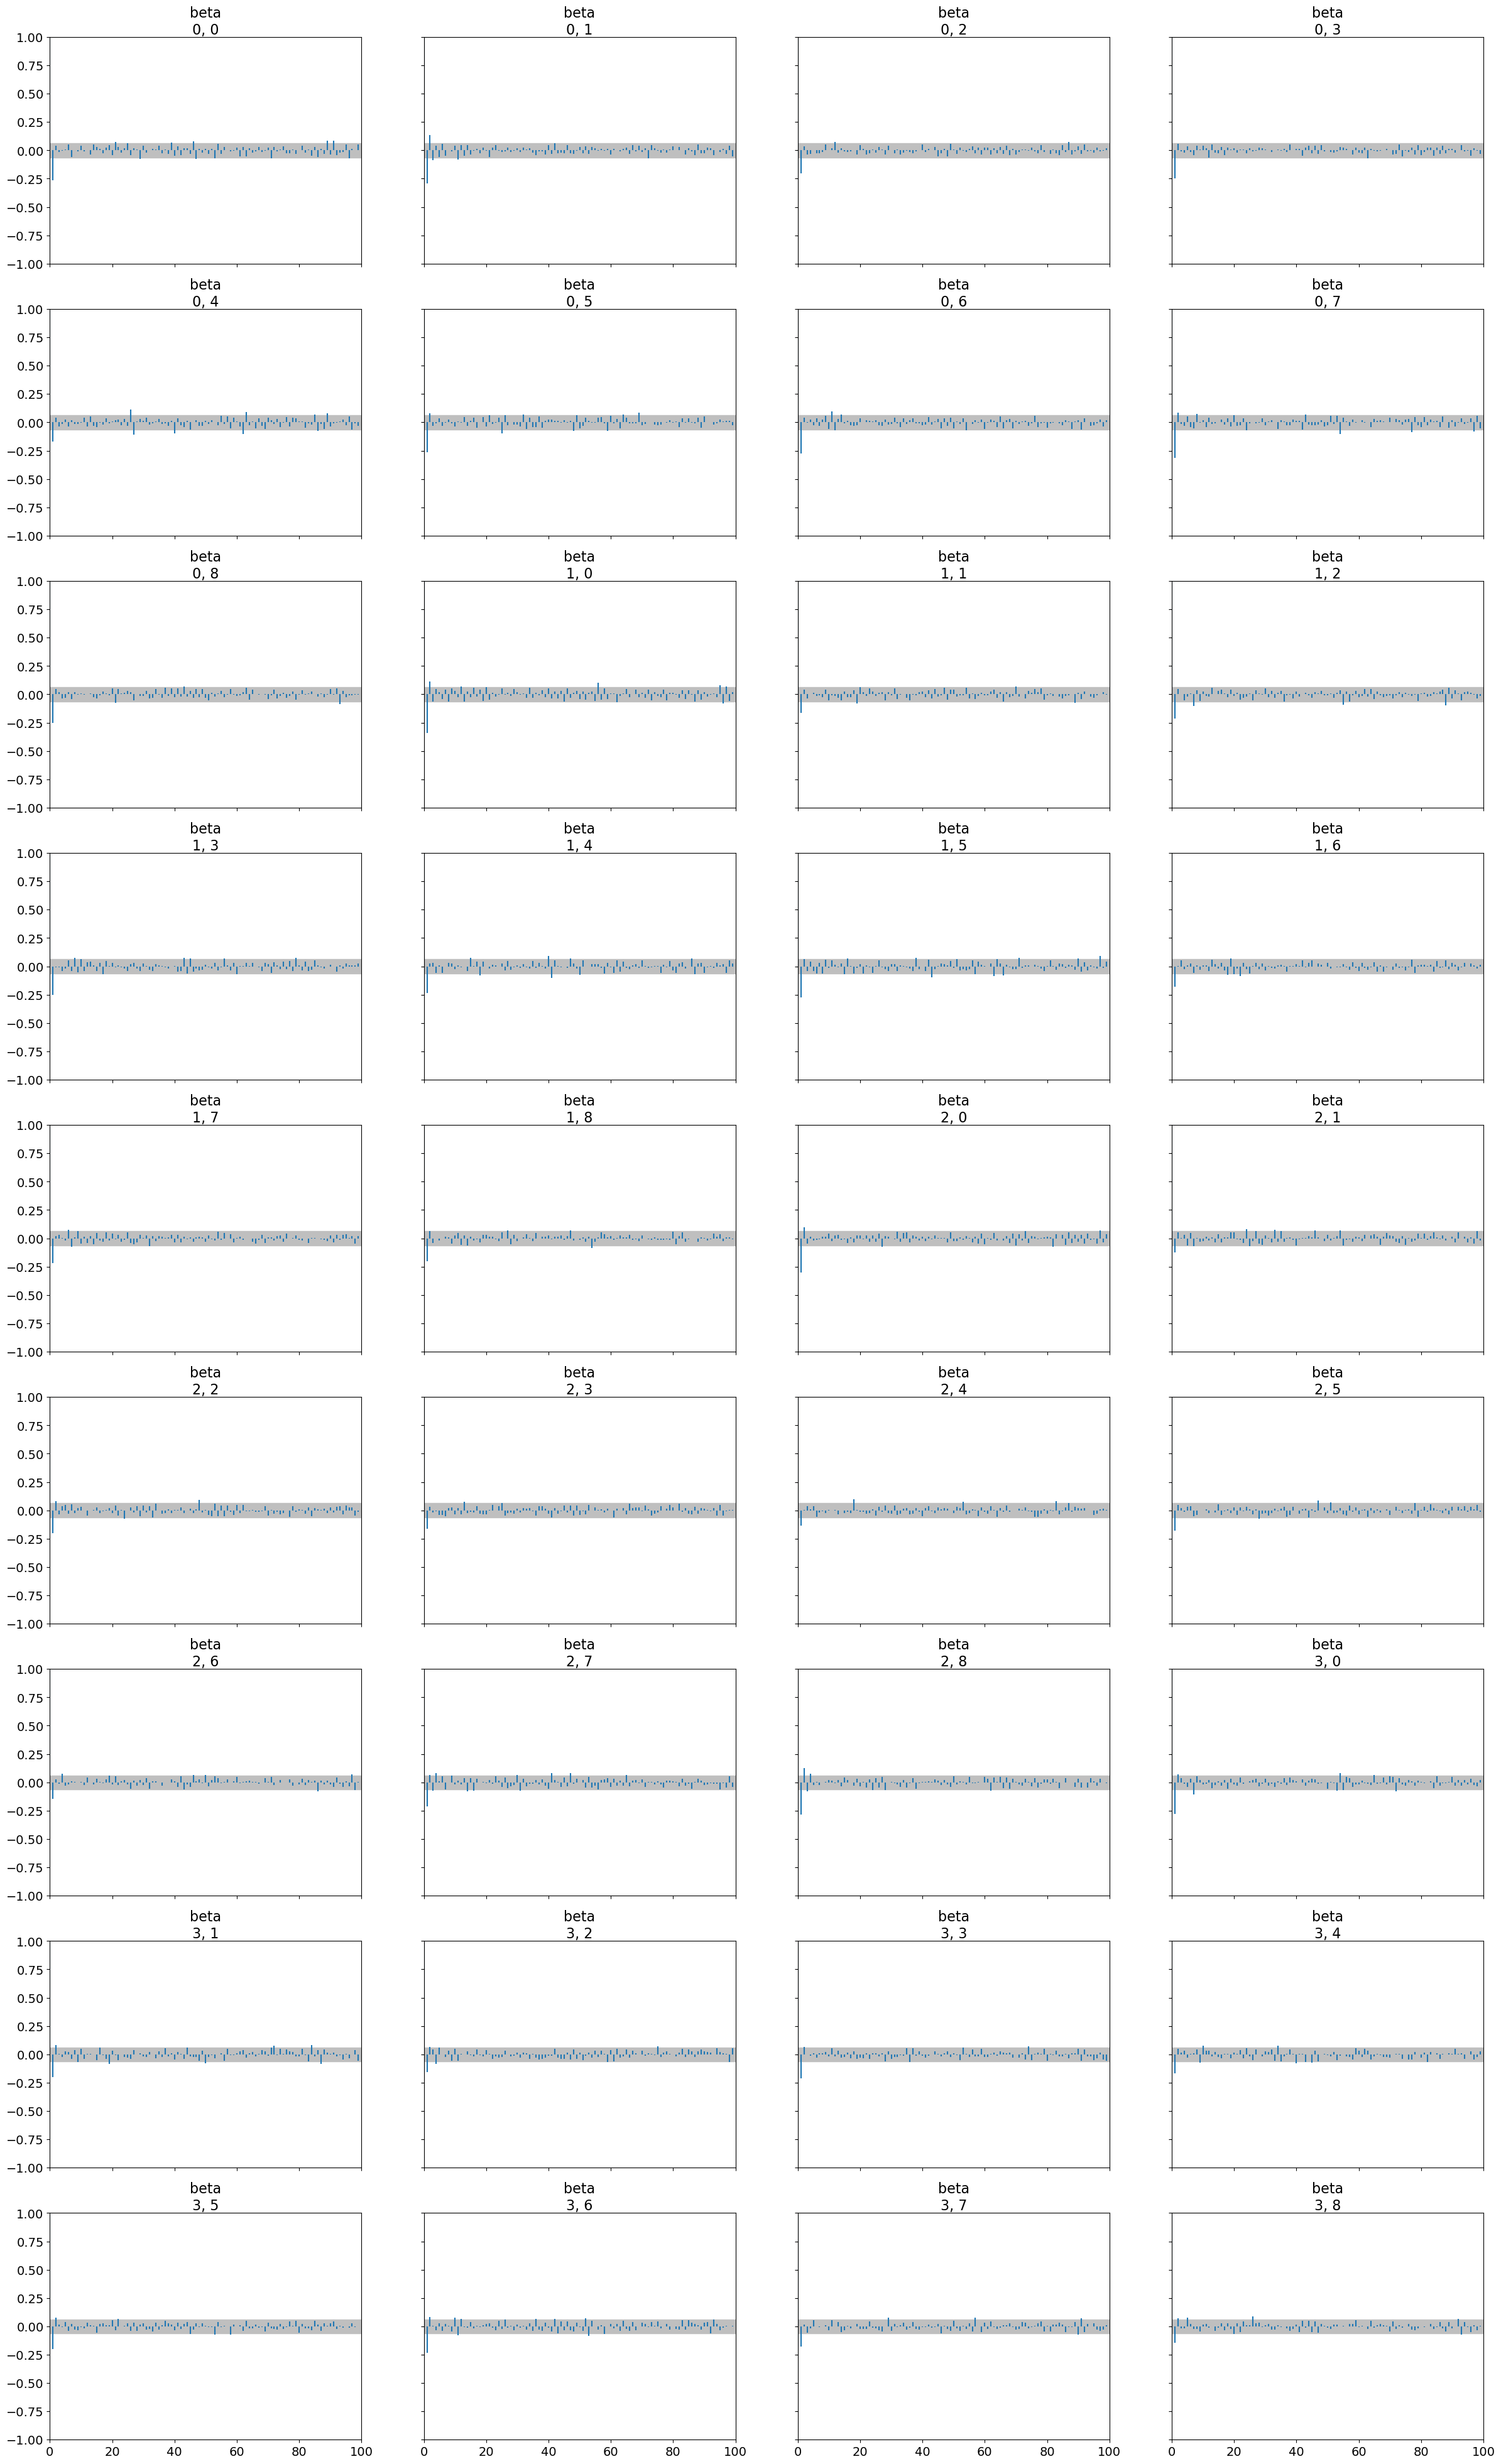

In [52]:
import arviz as az

# Diagnostic plots
az.plot_trace(trace, var_names=["beta"])
az.plot_autocorr(trace, var_names=["beta"])

# summary, more disagnostics
az.summary(trace, var_names=["beta"]) 

## Part 2 

In [53]:
from scipy.optimize import minimize
import numpy as np

def neg_log_posterior(beta, X, y, alpha):
    mu = np.exp(X @ beta)
    return - ((y @ (X @ beta)) - np.sum(mu) - (0.5 / alpha) * np.sum(beta ** 2))

def grad(beta, X, y, alpha):
    mu = np.exp(X @ beta)
    return - (X.T @ y - X.T @ mu - 1/ alpha * beta)

def hessian(beta, X, y, alpha):
    mu = np.exp(X @ beta)
    W = np.diag(mu)
    H = X.T @ W @ X + (1 / alpha) * np.eye(len(beta)) 
    return H

beta0 = np.zeros(X.shape[1])
res = minimize(neg_log_posterior, beta0, args=(X,y,alpha), 
               method = "Newton-CG", jac=grad, hess=hessian)

beta_mean = res.x
H = hessian(beta_mean, X, y, alpha)
Sigma = np.linalg.inv(H)

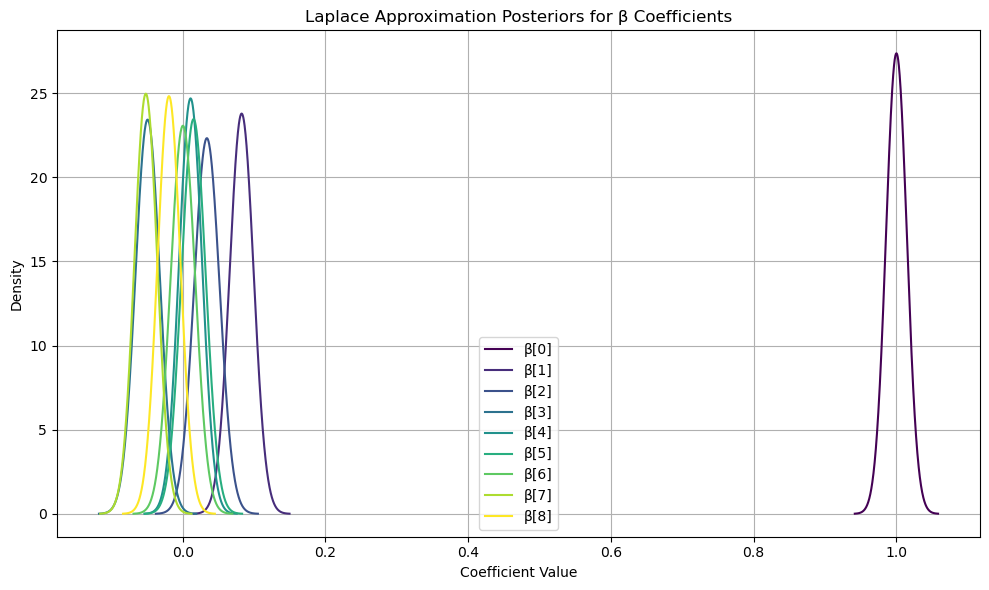

In [55]:
from scipy.stats import norm
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

colors = plt.cm.viridis(np.linspace(0, 1, len(beta_mean)))

for i, (mean_i, color) in enumerate(zip(beta_mean, colors)):
    std_i = np.sqrt(Sigma[i, i])
    
    if std_i <= 0 or np.isnan(std_i):
        continue  # Skip invalid variances
    
    x = np.linspace(mean_i - 4 * std_i, mean_i + 4 * std_i, 500)
    plt.plot(x, norm.pdf(x, mean_i, std_i), label=f"β[{i}]", color=color)

plt.title("Laplace Approximation Posteriors for β Coefficients")
plt.xlabel("Coefficient Value")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()